# Subgraph Localization

**Author**: Amit Boyarski & Dani Kogan

## Intro

Let $\mathcal{G}$ be a graph with $n$ nodes, possibly directed, and let $\mathcal{G}_{sub}$ be another graph with $m<n$ nodes. 
Our problem is to find a subgraph of $\mathcal{G}$ which is as close as possible to $\mathcal{G}_{sub}$ according to some graph similarity metric $d(\mathcal{G}, \mathcal{G}_{sub})$.  For example, if $\mathcal{G}_{sub}$ consists of a subset of edges of $\mathcal{G}$ and their incident nodes, the problem is to identify those edges (from which the nodes could be identified). 

For simplicity we shall phrase the problem in terms of directly identifying the nodes rather than the edges. Any node identification algorithm can be turned into an edge identification algorithm by applying it to the *line graphs* of $\mathcal{G}$ and $\mathcal{G}_{sub}$.  We also phrase the algorithm in terms of undirected graphs. In order to account for the direction, we apply an invertible symmetrization to the graphs as a pre-process, e.g., transforming the directed graph into an undirected bipartite graph.
 
Let $\mathbf{w}$ denote a discrete probability distribution on the nodes of  $\mathcal{G}$, i.e., $0\leq w_i \leq 1$ satisfying $\sum_{i=1}^{n}{w_i} = 1$ is the probability for sampling the node $i$.  A vector $\mathbf{w}_{sub}$ representing the nodes of $\mathcal{G}_{sub}$ would be a uniform distribution on the nodes of $\mathcal{G}$ that is concentrated on the nodes of $\mathcal{G}_{sub}$, i.e., 

$$
\mathbf{w}_{sub}[i] = \begin{cases} 1/m &\;\;\;\;  i\in \mathcal{N}(\mathcal{G}_{sub})\\
 0 & \;\;\;\;otherwise.
 \end{cases}
$$
 
In order to optimize for $\mathbf{w}$, we define two functions:

- A node classification function $\texttt{classify}$ parametrized by $\theta$, which generates a vector $\mathbf{w}$ from $\mathcal{G}, \mathcal{G}_{sub}$, i.e.
$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub}; \theta)
$$

- A permutation invariant graph embedding function $\texttt{embed}$ parametrized by $\mathbf{\phi}$ which satisfies the following condition:

$$
$d\left(\texttt{embed}(\mathcal{G}, \mathbf{w}_{sub} ; \phi), $\texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1} ; \phi)\right) \approx 0  
$$

Our complete algorithm consists of two steps:

- *Training* : Shaping the graph metric 

$$
d\left(\texttt{embed}(\mathcal{G}_1, \mathbf{w}_1 ; \phi), $\texttt{embed}(\mathcal{G}_2, \mathbf{w}_2 ; \phi)\right)
$$

via supervised learning, e.g., learning $\phi$ via contrastive learning.

- *Inference*: Optimizing for $\theta$ given $\phi$:

$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub} ; \theta)\\
\mathbf{v} = \texttt{embed}(\mathcal{G}, \mathbf{w}, ; \phi)\\
\mathbf{v}_{sub} = \texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1}, ; \phi)
$$

$$
\min_{\theta} d(\mathbf{v},\mathbf{v}_{sub})^2 + \rho \cdot \texttt{reg}(\mathcal{G}, \mathbf{w})
$$

The purpose of the $\texttt{reg}$ function is to promote $\mathbf{w}$ to be piecewise constant on the graph.

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import \
    EmbeddingMetricNetwork
from subgraph_matching_via_nn.composite_nn.composite_nn import CompositeNeuralNetwork
import torch
from subgraph_matching_via_nn.utils.utils import plot_indicator
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor
from subgraph_matching_via_nn.data.data_loaders import load_graph
from subgraph_matching_via_nn.data.paths import *
from subgraph_matching_via_nn.data.paths import DATA_PATH
from subgraph_matching_via_nn.utils.plot_services import PlotServices
from subgraph_matching_via_nn.composite_nn.composite_solver import BaseCompositeSolver
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_network_factory import \
    NodeClassifierNetworkFactory, NodeClassifierLastLayerType, NodeClassifierNetworkType
from subgraph_matching_via_nn.graph_embedding_networks.graph_embedding_network_factory import \
    GraphEmbeddingNetworkFactory, EmbeddingNetworkType
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    binary_penalty, graph_entropy, spectral_reg, graph_total_variation
from subgraph_matching_via_nn.mask_binarization.indicator_dsitribution_binarizer import IndicatorBinarizationType, \
    IndicatorDistributionBinarizer, IndicatorBinarizationBootType

plt.rcParams["figure.figsize"] = (6, 3)  # Set the desired figure size (width, height)

Load graph and subgraph

In [2]:
# Set the size of the graph and the subgraph
n = 10  # Number of nodes in the graph (for random graph)
m = 7  # Number of nodes in the subgraph (for random graph)

seed = 10  # for plotting
plot_services = PlotServices(seed)

loader_params = {'graph_size': n,
                 'subgraph_size': m,
                 'data_path' : DATA_PATH,
                 'g_full_path': COMP1_FULL_path,
                 'g_sub_path': COMP1_SUB0_path}

sub_graph = \
    load_graph(type='random',
               loader_params=loader_params) # type = 'random', 'example', 'subcircuit'
G = sub_graph.G
G_sub = sub_graph.G_sub

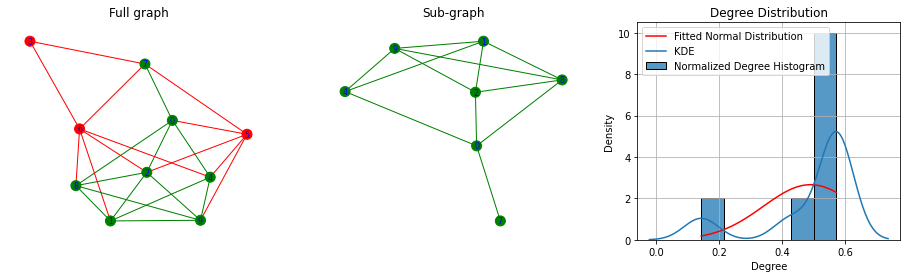

First 6 moments: ['0.4898', '0.2624', '0.1449', '0.0810', '0.0456', '0.0258']


In [3]:
plot_services.plot_graph_alongside_subgraph_with_degree_distribution(sub_graph, n_moments = 6)

Line graph transformation

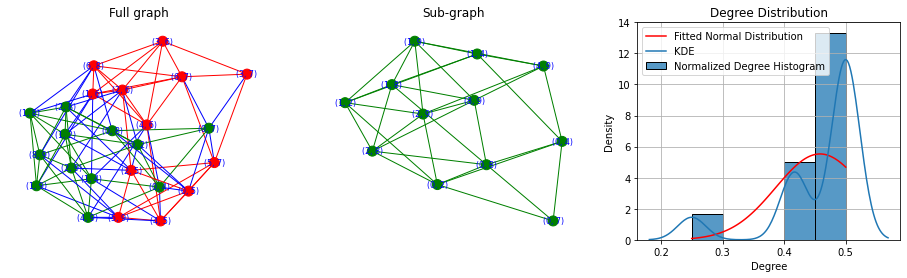

First 6 moments: ['0.4583', '0.2153', '0.1027', '0.0495', '0.0241', '0.0117']


In [4]:
to_line = True

graph_processor = GraphProcessor(params={'to_line':  to_line})
processed_sub_graph = graph_processor.pre_process(sub_graph)

processed_G = processed_sub_graph.G

plot_services.plot_graph_alongside_subgraph_with_degree_distribution(processed_sub_graph, n_moments = 6)

Build localization network

In [5]:
params = {}
params["maxiter"] = 5000
params["lr"] = 0.0000002  # 0.0002 is good
params["n_moments"] = 4
params["m"] = len(processed_sub_graph.G_sub.nodes())
params["k_update_plot"] = 250
params['spectral_op_type'] = 'Laplacian' # 'Laplacian'. 'Adjacency'
params["moment_type"] = "standardized_raw"  # options: 'central' ,'raw', 'standardized_raw', 'standardized_central'
params["reg_params"] = [0]  # reg param  # 0.02  is good
params["reg_terms"] = [graph_total_variation]
params["quantile_level"] = (n-m)/m

node_classifier_network = NodeClassifierNetworkFactory.create_node_classifier_network(processed_G,
                                                                                      NodeClassifierLastLayerType.SquaredNormalized, NodeClassifierNetworkType.Identity, params)
node_classifier_network.train_node_classifier(G_sub=sub_graph.G_sub, graph_generator=None)

embedding_nns = GraphEmbeddingNetworkFactory.create_embedding_networks(sub_graph, params,
                                                                       [EmbeddingNetworkType.Moments, EmbeddingNetworkType.Spectral])

composite_nn = CompositeNeuralNetwork(node_classifier_network=node_classifier_network,
                                      embedding_networks=embedding_nns)
embedding_metric_nn = EmbeddingMetricNetwork(loss_fun=torch.nn.MSELoss())

Initialize the localization parameters

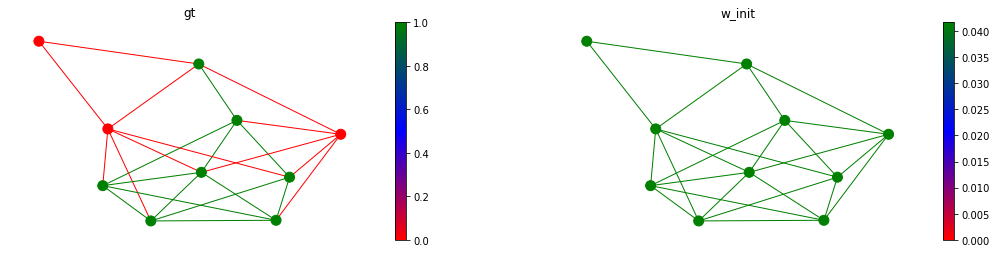

['0.9894', '1.0261', '1.0651'] : init standardized_raw moments
['0.9878', '1.0284', '1.0687'] : sub standardized_raw moments
['0.9878', '1.0284', '1.0687'] : GT standardized_raw moments
['62.7307', '8.8464', '9.7437', '10.9736', '11.2623', '11.7951', '12.5915', '12.9494', '13.6157'] : init Laplacian eigs
['0.0000', '2.0954', '3.5767', '4.5858', '5.0000', '5.0000', '6.8699', '7.4142', '7.4579'] : sub Laplacian eigs
['0.0000', '2.0954', '3.5767', '4.5858', '5.0000', '5.0000', '6.8699', '7.4142', '7.4579'] : GT Laplacian eigs
init loss (no reg): 471.8042230620043
init full loss (with reg): 471.8042230620043


In [6]:
gt_indicator = sub_graph.edge_indicator if to_line else sub_graph.node_indicator
gt_indicator_tensor = composite_nn.init_network_with_indicator(processed_sub_graph)
w_init = node_classifier_network(A=processed_sub_graph.A_full,
                                              params=params).detach().numpy()

plot_services.plot_subgraph_gt_vs_initial_indicators(sub_graph, processed_sub_graph, w_init, gt_indicator)

# compute loss and embedding at init
composite_solver = BaseCompositeSolver(composite_nn, embedding_metric_nn, graph_processor, params)
loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, gt_indicator_tensor, A_sub_indicator=None)

Localization experiments

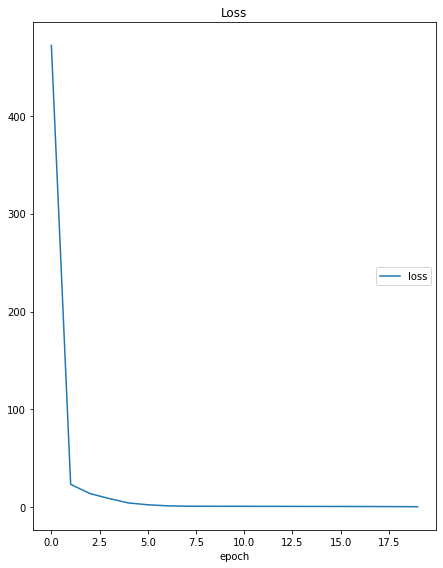

Loss
	loss             	 (min:    0.641, max:  471.804, cur:    0.641)


In [7]:
w_all = []
num_rand_exp = 1

for k in range(num_rand_exp):
    print(k)
    _ = composite_nn.init_network_with_indicator(processed_sub_graph)

    w_star = composite_solver.solve(G=sub_graph.G,
                             G_sub=sub_graph.G_sub)

    # x0 = composite_solver.set_initial_params_based_on_previous_optimum(w_star) #TODO?

    w_all.append(w_star)

Binarize output mask

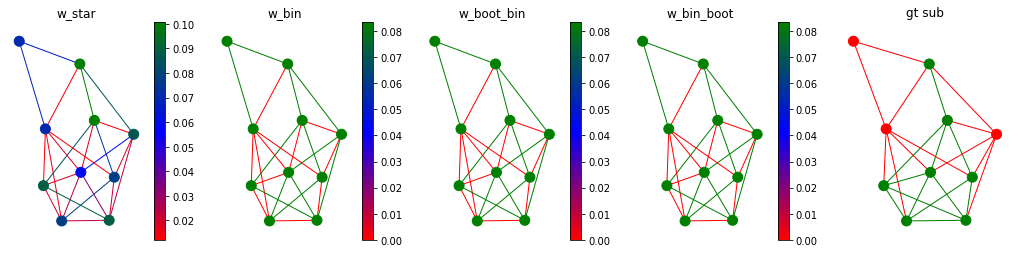

In [8]:
binarization_type = IndicatorBinarizationType.TopK
series_binarization = IndicatorDistributionBinarizer.from_indicators_series_to_binary_indicator

w_star = node_classifier_network(A = processed_sub_graph.A_full, params = params).detach().numpy()
w_star_dict = dict(zip(processed_G.nodes(), w_star))

w_bin_dict = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.OptimalElement, binarization_type)

w_boot_dict_bin = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.SeriesNormalizedMean, binarization_type)

w_binarize_boot_dict = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.SeriesMedianOfBinarizedElements, binarization_type)

indicator_name_to_object_map = {'w_star': w_star_dict, 'w_bin': w_bin_dict, 'w_boot_bin': w_boot_dict_bin, 'w_bin_boot': w_binarize_boot_dict}
plot_services.plot_subgraph_indicators(G, G_sub, to_line, indicator_name_to_object_map)

Compare indicators and their embeddings

['0.9739', '1.0688', '1.1798'] : init standardized_raw moments
['0.9878', '1.0284', '1.0687'] : sub standardized_raw moments
['0.9878', '1.0284', '1.0687'] : GT standardized_raw moments
['0.0106', '2.1263', '3.4865', '4.4858', '4.9702', '5.1372', '7.1292', '7.4907', '9.2478'] : init Laplacian eigs
['0.0000', '2.0954', '3.5767', '4.5858', '5.0000', '5.0000', '6.8699', '7.4142', '7.4579'] : sub Laplacian eigs
['-0.0000', '2.0954', '3.5767', '4.5858', '5.0000', '5.0000', '6.8699', '7.4142', '7.4579'] : GT Laplacian eigs
init loss (no reg): 0.373142792780958
init full loss (with reg): 0.373142792780958
['0.0106', '2.1263', '3.4865', '4.4858', '4.9702', '5.1372', '7.1292', '7.4907', '9.2478'] : est Laplacian eigs
['0.0000', '0.5362', '1.1001', '1.3809', '2.1063', '3.3134', '3.5884', '4.3103', '5.0710'] : est_bin Laplacian eigs
['0.0000', '0.5362', '1.1001', '1.3809', '2.1063', '3.3134', '3.5884', '4.3103', '5.0710'] : est_boot_bin Laplacian eigs
['0.0000', '0.5362', '1.1001', '1.3809', '2.1

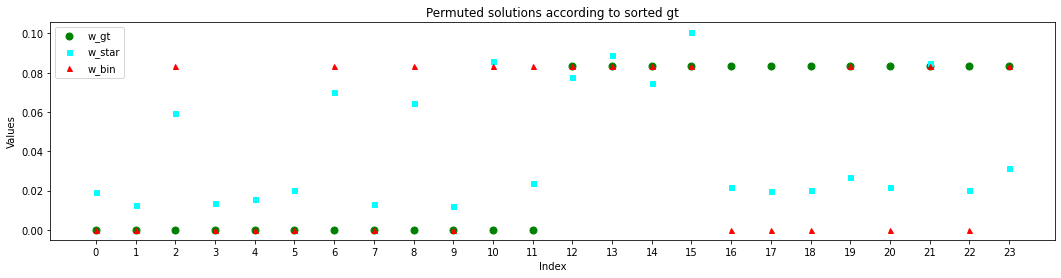

In [9]:
idx = 1 # to choose which embedding to plot

gt_node_distribution_processed = processed_sub_graph.w_gt
loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, gt_node_distribution_processed, A_sub_indicator=None)
composite_solver.compare_indicators(processed_sub_graph.A_full, {'est': w_star, 'est_bin': list(w_bin_dict.values()),
                                                       'est_boot_bin': list(w_boot_dict_bin.values()), 'est_bin_boot_bin': list(w_binarize_boot_dict.values())}, idx)

reg_terms_names = [reg_terms.__name__ for reg_terms in params['reg_terms']]

print(f"\n{to_line = }")
print(f"\nloss = {loss}, reg_params = {params['reg_params']}, reg_terms = {reg_terms_names}")
print(f"loss_ref = {ref_loss}, reg_param = {params['reg_params']}, reg_terms = {reg_terms_names}")
print(f"\nRemark: embeddings_gt and embeddings_sub might differ if we don't transform to line graph because node indicator can at best give a superset of the edges of the subgraph.")

plot_indicator([gt_node_distribution_processed, w_star, np.array(list(w_bin_dict.values()))], ['w_gt', 'w_star', 'w_bin'])